In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from datetime import datetime
from src.support_class import *
from src.objComposite import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
from codeStore import support_fun_resistance as spf_re
# %matplotlib notebook

PWD = os.getcwd()
np.set_printoptions(linewidth=110, precision=5)

params = {'animation.html': 'html5',
          'font.family':    'sans-serif',
          'font.size':      20, }
preamble = r' '
preamble = preamble + '\\usepackage{bm} '
preamble = preamble + '\\usepackage{amsmath} '
preamble = preamble + '\\usepackage{amssymb} '
preamble = preamble + '\\usepackage{mathrsfs} '
preamble = preamble + '\\DeclareMathOperator{\\Tr}{Tr} '
params['text.latex.preamble'] = preamble
params['text.usetex'] = True
plt.rcParams.update(params)


In [6]:
job_dir = 'hlx_th0'

tdir = os.path.join(os.getcwd(), job_dir)
problem_kwarg_list, A_list, B1_list, B2_list, C_list = spf_re.load_ABC_list(tdir)
TrA_list = np.array([i0[2] for i0 in A_list])
TrB1_list = np.array([i0[2] for i0 in B1_list])
TrB2_list = np.array([i0[2] for i0 in B2_list])
TrC_list = np.array([i0[2] for i0 in C_list])
ph_list = np.array([i0['ph'] for i0 in problem_kwarg_list])
ch_list = np.array([i0['ch'] for i0 in problem_kwarg_list])
helicoid_r_list = np.array([i0['helicoid_r'] for i0 in problem_kwarg_list])

data = pd.DataFrame({'TrA': TrA_list, 
                     'TrB1': TrB1_list, 
                     'TrB2': TrB2_list, 
                     'TrC': TrC_list, 
                     'ph': ph_list, 
                     'ch': ch_list, 
                     'helicoid_r': helicoid_r_list, 
                     }).pivot_table(index=['ph', 'ch'], columns=['helicoid_r'])

save figure to FIG/fig_helicoid_c100000.00_TrBTrA_1.pdf 


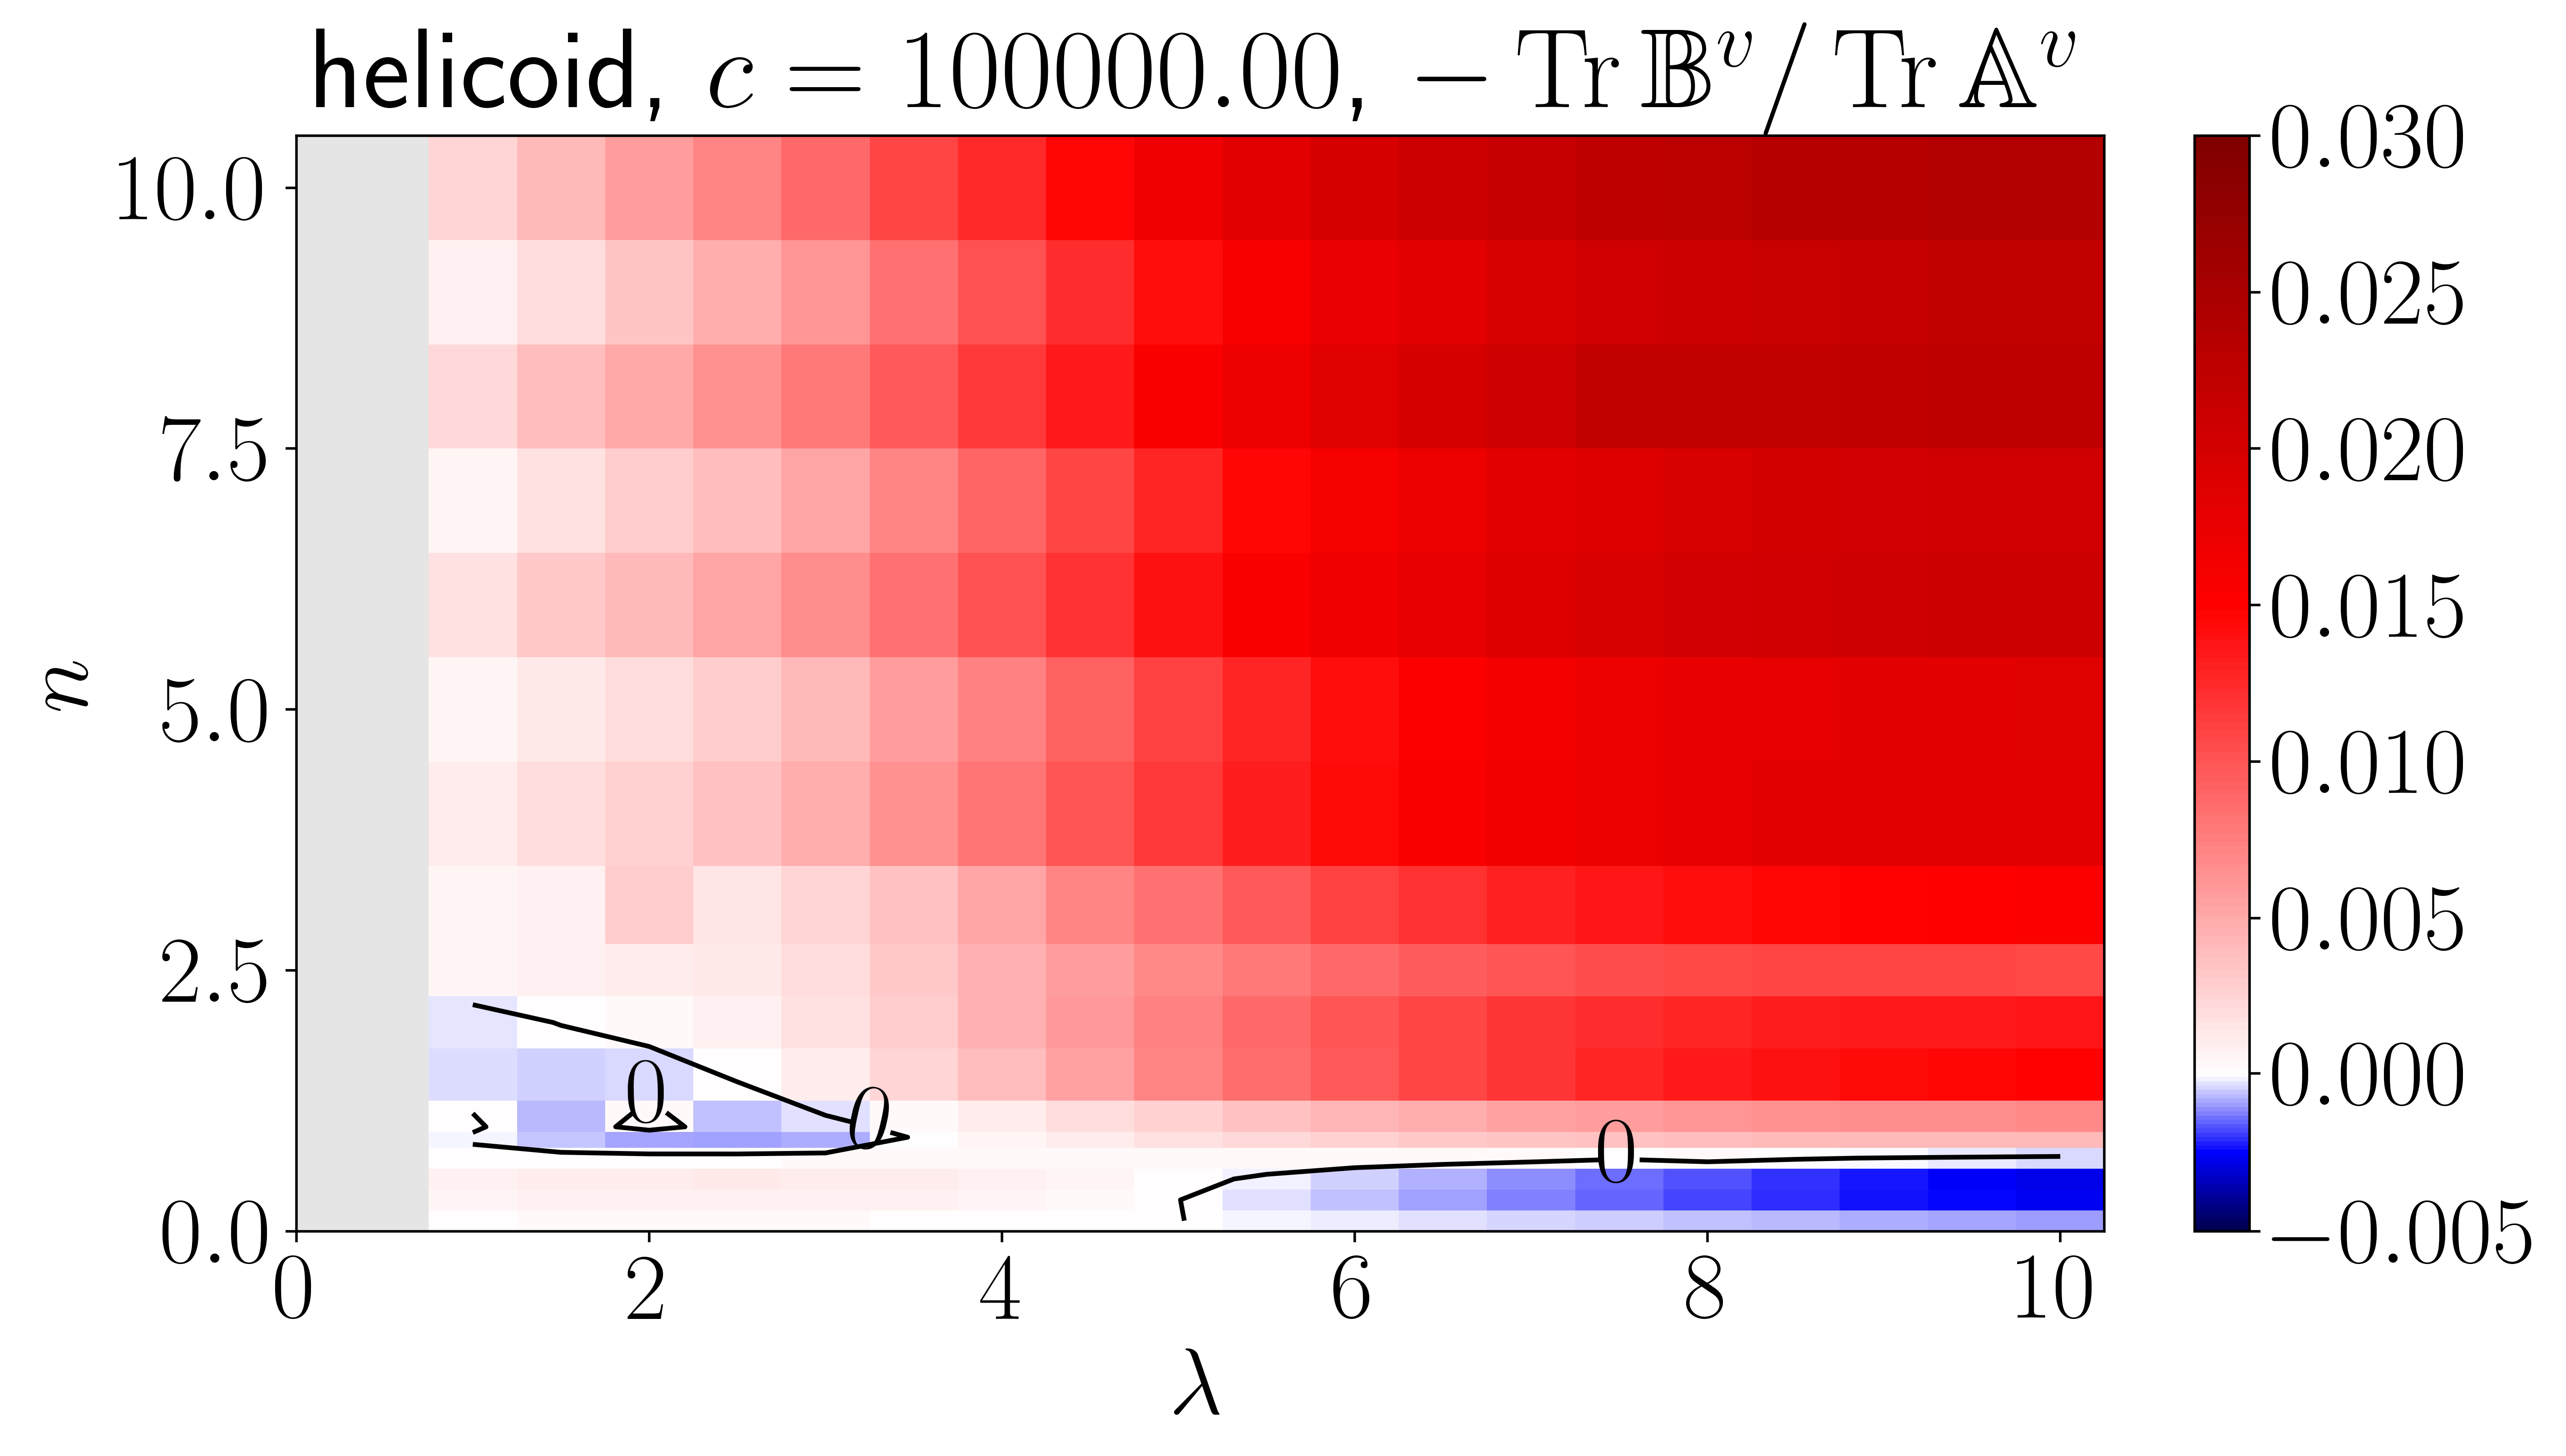

In [15]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 15})
figsize=np.array((20, 9))*0.5
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
vmin, vmax, midpoint = -0.005, 0.03, 0
cmap = plt.get_cmap('seismic')
norm = spf.midLinearNorm(midpoint=midpoint, vmin=vmin, vmax=vmax)

# for helicoid_r in data.TrA.columns.values[:]:
#     fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
#     fig.patch.set_facecolor('white')

#     t1 = (-data.TrB1 / data.TrA)[helicoid_r].unstack()
#     tph = t1.index.values  # ph
#     tch = t1.columns.values  # ch
#     tvalue = t1.values.T
#     axi = axs[0]
#     # im = axi.pcolor(tph, tch, t1.values.T, vmin=vmin, vmax=vmax)
#     im = axi.pcolormesh(tph, tch, tvalue, cmap=cmap, norm=norm, shading='auto')
#     cs = axi.contour(tph, tch, tvalue, [0, ], colors='k')
#     axi.clabel(cs, inline=True)
#     fig.colorbar(im, ax=axi, orientation='vertical')
#     axi.set_xlabel('$\\lambda$')
#     axi.set_ylabel('$n$')
#     axi.set_title('$c=%f$' % helicoid_r)

#     t1 = (-data.TrB2 / data.TrA)[helicoid_r].unstack()
#     tph = t1.index.values  # ph
#     tch = t1.columns.values  # ch
#     tvalue = t1.values.T
#     axi = axs[1]
#     # im = axi.pcolor(tph, tch, t1.values.T, vmin=vmin, vmax=vmax)
#     im = axi.pcolormesh(tph, tch, tvalue, cmap=cmap, norm=norm, shading='auto')
#     cs = axi.contour(tph, tch, tvalue, [0, ], colors='k')
#     axi.clabel(cs, inline=True)
#     fig.colorbar(im, ax=axi, orientation='vertical')
#     axi.set_xlabel('$\\lambda$')
#     axi.set_ylabel('$n$')
    
# ----------------------------------------------------------------------------------
plt.rcParams.update({'font.size': 30})
figsize=np.array((16, 9)) * 0.7
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
vmin, vmax, midpoint = -0.005, 0.03, 0
cmap = plt.get_cmap('seismic')
norm = spf.midLinearNorm(midpoint=midpoint, vmin=vmin, vmax=vmax)

for helicoid_r in data.TrA.columns.values[:]:
    fig, axs = plt.subplots(1, 1, figsize=figsize, dpi=dpi, constrained_layout=True)
    fig.patch.set_facecolor('white')

    t1 = (-data.TrB1 / data.TrA)[helicoid_r].unstack()
    tph = t1.index.values  # ph
    tch = t1.columns.values  # ch
    tvalue = t1.values.T
    axi = axs
    im = axi.pcolormesh(tph, tch, tvalue, cmap=cmap, norm=norm, shading='auto')
    cs = axi.contour(tph, tch, tvalue, [0, ], colors='k')
    axi.clabel(cs, inline=True)
    fig.colorbar(im, ax=axi, orientation='vertical')
    axi.set_xlabel('$\\lambda$')
    axi.set_ylabel('$n$')
    axi.set_xlim((0, axi.get_xlim()[1]))
    axi.set_ylim((0, axi.get_ylim()[1]))
    axi.patch.set_facecolor('grey')
    axi.patch.set_alpha(0.2)
    axi.set_title('helicoid, $c=%.2f$, $-\\Tr \\mathbb{B}^v / \\Tr \\mathbb{A}^v$' % helicoid_r)

    fig_name = 'FIG/fig_helicoid_c%.2f_TrBTrA_1.pdf' % helicoid_r
    fig.savefig(fig_name)
    print('save figure to %s ' % fig_name)

In [4]:
data.TrB1

helicoid_r   100000.0
ph   ch              
1.0  0.1     0.008515
     0.3     0.051385
     0.5     0.090099
     0.7     0.028558
     0.9    -0.016720
...               ...
10.0 6.0    27.385496
     7.0    30.416687
     8.0    37.448560
     9.0    40.113387
     10.0   47.613725

[323 rows x 1 columns]